In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from numpy.linalg import norm
from dtw import dtw

In [2]:
def manipulate_speed(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

In [3]:
#orginal audio
data, sr = librosa.load('audio.wav',sr = 16000)
ipd.Audio(data,rate = sr)

(-0.5, 221.5)

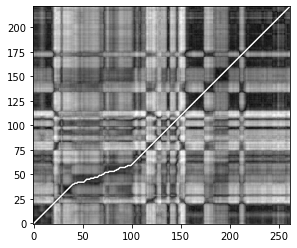

In [4]:
prolonged = data[20286:51156]
fast = np.array(manipulate_speed(prolonged,3))


hop_length=hop_length = 512


#perfect sentence formation
d = list(data)
fast = d[0:20286]+list(fast)+d[51156:] #word name is fast

mfcc1 = librosa.feature.mfcc(data, sr,hop_length=hop_length)
mfcc2 = librosa.feature.mfcc(np.array(fast), sr,hop_length=hop_length)


dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
plt.imshow(cost.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

(-0.5, 321.5)

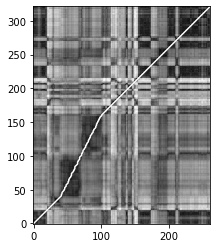

In [42]:
prolonged = data[20286:51156]
slow = np.array(manipulate_speed(prolonged,0.5))



#perfect sentence formation
d = list(data)
slow = d[0:20286]+list(slow)+d[51156:] #word name is fast

mfcc1 = librosa.feature.mfcc(data, sr)
mfcc2 = librosa.feature.mfcc(np.array(slow), sr)



dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
plt.imshow(cost.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

In [6]:
import scipy
import sys  
from scipy import signal
from scipy import pi
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np    
from scipy.signal import butter, lfilter, freqz   
from aubio import source, pitch
from numpy import inf,isnan

In [75]:
def preprocessing(data):
    fs = 16000                                                       #sampling rate
    cutoff = 75                                                      #cutoff for a high pass filter 
    nyq = 0.5 * fs                                                   #sampling therom
    order = 5
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  #get coefficients of butterworth high pass filter
    highpass_signal = lfilter(b,a,data)                            #high pass filtered signal 
    pre_emphasis = 0.97                                              #preempasis factor
    
    #pre-filtering attempts to equalize the effect of high frequency with respect to low frequency components.
    emphasized_signal = np.append(highpass_signal[0], highpass_signal[1:] - pre_emphasis * highpass_signal[:-1])
    return emphasized_signal
    
    
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]    
    
def f0(preprocessed_signal):
    #make a low pass filter with cut off frequency 6KHz
    cutoff = 600
    fs = 16000
    order = 5
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    lowpass_signal = lfilter(b,a,preprocessed_signal)
    
    librosa.output.write_wav('cleaned.wav',lowpass_signal, sr, norm=True)

    from aubio import pitch

    win_s = 4096
    hop_s = 400
    s = source('cleaned.wav', 16000, hop_s)
    samplerate = s.samplerate
    tolerance = 0.8
    pitch_o = pitch("yin", win_s, hop_s, samplerate)
    pitch_o.set_unit("midi")
    pitch_o.set_tolerance(tolerance)

    pitches = []                                                  #get fundemental frequencies
    confidences = []                                              #the confidences of the pitch values

    total_frames = 0
    while True:
        samples, read = s()
        pitch = pitch_o(samples)[0]
        pitches += [pitch]
        confidence = pitch_o.get_confidence()
        confidences += [confidence]
        total_frames += read
        if read < hop_s: break

    pitches = 12*(np.log(pitches))/(np.log(2))                  #get semitones 
    nans, x= nan_helper(pitches)
    pitches[nans]= np.interp(x(nans), x(~nans), pitches[~nans]) #remove nan values with values of linear interpolation
    normalize = pitches / np.linalg.norm(pitches)               #normalize the pitches
    median = scipy.signal.medfilt(normalize, kernel_size=3)     #pass a median filter
    return median 

def energy(signal):
    hop_length = 200
    
    return librosa.feature.rms(signal, hop_length=hop_length)[0]

In [76]:
ref_signal = preprocessing(data)         #preprocessed data
ref_f0 = f0(ref_signal)                  #post processing f0
ref_energy = energy(ref_signal)          #root mean square enrgy of a signal

student_signal = preprocessing(fast)     #preprocessed data
student_f0 = f0(student_signal)          #post processing f0
student_energy = energy(student_signal) #root mean square enrgy of a signal

C:\Users\lenovo\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log


(-0.5, 221.5)

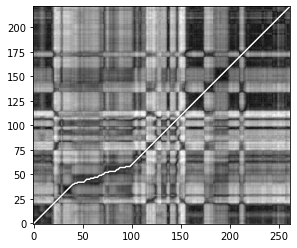

In [63]:

mfcc1 = librosa.feature.mfcc(ref_signal, sr )
mfcc2 = librosa.feature.mfcc(student_signal, sr )


dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
plt.imshow(cost.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

In [64]:
mfcc1.shape,ref_f0.shape,ref_energy.shape

((20, 262), (670,), (670,))

In [65]:
ref_t = np.linspace(0,librosa.get_duration(ref_signal),len(student_f0))
student_t = np.linspace(0,librosa.get_duration(student_signal),len(student_f0))

In [66]:
def wrap_time(path,t1,t2):
    time_wrapping = dict()
    if t1 < t2:
        for i,j in zip(path[0],path[1]): time_wrapping[i/43] = j/43
    else:
        for i,j in zip(path[0],path[1]): time_wrapping[j/43] = i/43
    return (list(time_wrapping.keys()),list(time_wrapping.values()))

time_wrap = wrap_time(path,librosa.get_duration(ref_signal),librosa.get_duration(student_signal))

In [67]:
len(ref_signal)

133956

In [90]:
def scoring(time_wrap,ref_signal,student_signal,alpha):
    length = len(time_wrap[0])
    
    ref_signal = preprocessing(data)         #preprocessed data
    student_signal = preprocessing(fast)     #preprocessed data
    
    fscore = []
    escore = []

    for i in range(int(length/2)-1):
        i= i*2        
        ref__signal = ref_signal[int(time_wrap[0][i]*16000): int(time_wrap[0][i+1]*16000)]
        student__signal = student_signal[int(time_wrap[1][i]*16000): int(time_wrap[1][i+1]*16000)]

        
        ref_f0 = f0(ref__signal)                  #post processing f0
        ref_energy = energy(ref__signal)          #root mean square enrgy of a signal

        student_f0 = f0(student__signal)          #post processing f0
        student_energy = energy(student__signal)  #root mean square enrgy of a signal
        
        f0_score = (np.mean(ref_f0) - np.mean(student_f0))**2
        ene_score =(np.mean(student__signal) - np.mean(student_energy))**2
        
        fscore.append(f0_score)
        escore.append(ene_score)
        
        
    score = np.sqrt(((np.array(fscore)**2))*alpha) + np.sqrt((np.array(escore)**2)*(1-alpha))
    print(np.std(score))
        
scoring(time_wrap,ref_signal,student_signal,alpha = 0.4)

0.03052992422834346
